# Data Exploration

## Install Dependencies

In [1]:
%pip install geopandas
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scipy
%pip install 'SQLAlchemy==1.4.46'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Packages

In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
from scipy.stats import pearsonr
from sqlalchemy import create_engine

## Load Data

In [3]:
con = create_engine('sqlite:///../data/data.sqlite')
df1 = pd.read_sql_table('over_time', con, index_col='Year')
df2 = pd.read_sql_table('by_states', con, index_col='State')

## Data Exploration

### Dataframe 1 - Over Time

In [4]:
df1.head()

,NR Overall,NR Electric,NR Plug-in-Hybrid,Amount SCP,Amount FCP,Amount CP,Increase SCP,Increase FCP,Increase CP
Year,,,,,,,,,
2022,2651357,470559,362093,50526,9302,59828,18378,4575,22953
2021,2622132,355961,325449,36641,6165,42806,13885,3137,17022
2020,2917678,194163,200469,26196,3969,30165,10445,2196,12641
2019,3607258,63281,45348,16682,2552,19234,9514,1417,10931
2018,3435778,36062,31442,9363,1417,10780,7319,1135,8454


We add two new columns to the dataframe to be able to better compare the different years
1. `Percentage Full-Electric` which is the percentage of new registrations of cars which drive fully electirc
2. `Percentage Plug-in-Hybrid` which is the percentage of new registrations of cars which are Plug-in-Hybrids

In [5]:
# Add columns for percentage of Electric and Plug-in-Hybrid New registrations
df1['Percentage Full-Electric'] = df1['NR Electric'] / df1['NR Overall']
df1['Percentage Plug-in-Hybrid'] = df1['NR Plug-in-Hybrid'] / df1['NR Overall']
df1.head()

,NR Overall,NR Electric,NR Plug-in-Hybrid,Amount SCP,Amount FCP,Amount CP,Increase SCP,Increase FCP,Increase CP,Percentage Full-Electric,Percentage Plug-in-Hybrid
Year,,,,,,,,,,,
2022,2651357,470559,362093,50526,9302,59828,18378,4575,22953,0.177479,0.136569
2021,2622132,355961,325449,36641,6165,42806,13885,3137,17022,0.135753,0.124116
2020,2917678,194163,200469,26196,3969,30165,10445,2196,12641,0.066547,0.068708
2019,3607258,63281,45348,16682,2552,19234,9514,1417,10931,0.017543,0.012571
2018,3435778,36062,31442,9363,1417,10780,7319,1135,8454,0.010496,0.009151


To get a feeling for the correlation between the amount of charging points and the new registrations of electric powered cars, we combine both features in one plot. <br>
For this we plot the percentage share of new registrations in each year as bars and the amount of charging points at the start of the year as a line.

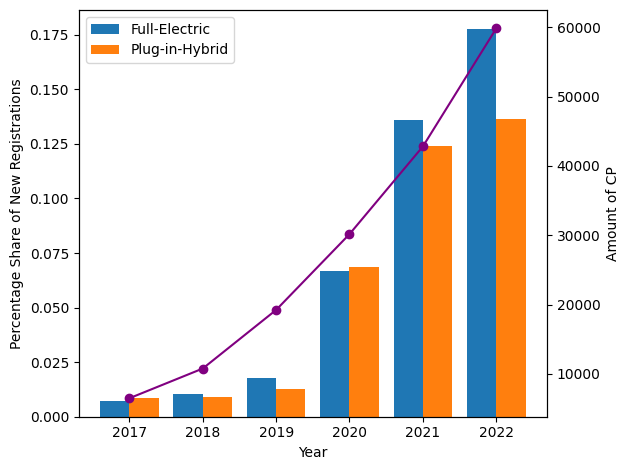

In [6]:
# Sort ascending by the years to get the plot right
df1.sort_index(ascending=True, inplace=True)
X = df1.index
X_axis = np.arange(len(X))


fig, ax1 = plt.subplots()

ax1.bar(X_axis-0.2, df1['Percentage Full-Electric'], 0.4)
ax1.bar(X_axis+0.2, df1['Percentage Plug-in-Hybrid'], 0.4)
ax1.legend(['Full-Electric', 'Plug-in-Hybrid'])
ax1.set_ylabel('Percentage Share of New Registrations')
ax1.set_xlabel('Year')
plt.xticks(X_axis, X)

ax2 = ax1.twinx()

ax2.plot(X_axis, df1['Amount CP'], 'o-', color='purple')
ax2.set_ylabel('Amount of CP')

fig.tight_layout()
plt.show()

In a second plot we show the summed amount of new registrations of cars which are electric powered (either fully electric or via plug-in-hybrid) in relation to the amount of charging points.

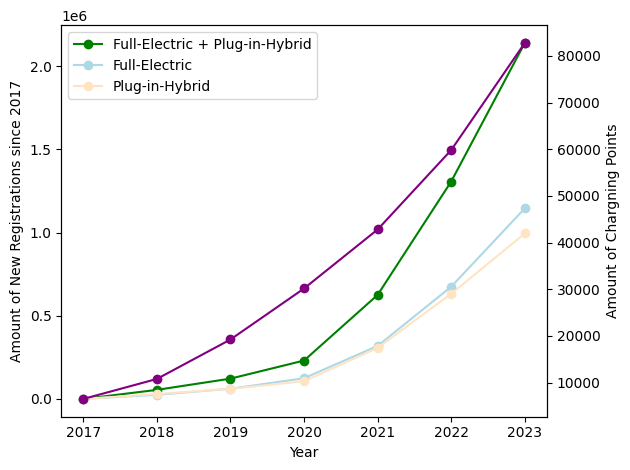

In [7]:
d = df1.copy()
d.loc[2023, 'Amount CP'] = d.loc[2022, 'Amount CP'] + d.loc[2022, 'Increase CP']
d['Sum Electric'] = d['NR Electric'].cumsum().shift(1).replace(np.NAN, 0)
d['Sum Plug-in-Hybrid'] = d['NR Plug-in-Hybrid'].cumsum().shift(1).replace(np.NAN, 0)

X = d.index
fig, ax1 = plt.subplots()

ax1.plot(X, d['Sum Electric']+d['Sum Plug-in-Hybrid'], 'o-', color='green')
ax1.plot(X, d['Sum Electric'], 'o-', color='lightblue')
ax1.plot(X, d['Sum Plug-in-Hybrid'], 'o-', color='bisque')
ax1.legend(['Full-Electric + Plug-in-Hybrid', 'Full-Electric', 'Plug-in-Hybrid'])
ax1.set_ylabel('Amount of New Registrations since 2017')
ax1.set_xlabel('Year')

ax2 = ax1.twinx()

ax2.plot(X, d['Amount CP'], 'o-', color='purple')
ax2.set_ylabel('Amount of Chargning Points')

fig.tight_layout()
plt.show()

For more detailed analysis we want to see if the values correlate by looking at the correlation coefficients. <br>
For calculating the correlations we use the scipy function pearsonr, which calculates the pearons correlation coefficient and the associated p-value. <br>
Docs: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pearsonr.html

In [8]:
# Add a new column for percentage of electric new registrations in total
df1['Percentage Electric'] = (df1['NR Electric'] + df1['NR Plug-in-Hybrid'])/df1['NR Overall']

cols1 = ['Amount CP', 'Amount SCP', 'Amount FCP']
cols2 = ['Percentage Full-Electric', 'Percentage Plug-in-Hybrid', 'Percentage Electric']

correlations = []

for c1 in cols1:
    for c2 in cols2:
        corr, pvalue = pearsonr(df1[c1], df1[c2])
        correlations.append({
            'x':c1,
            'y':c2,
            'corr_coef':corr,
            'p_value':pvalue
        })

df_corr = pd.DataFrame(correlations, columns=['x','y','corr_coef', 'p_value'])
df_corr.sort_values('corr_coef', ascending=False)

,x,y,corr_coef,p_value
0,Amount CP,Percentage Full-Electric,0.981682,0.000500
6,Amount FCP,Percentage Full-Electric,0.981597,0.000505
3,Amount SCP,Percentage Full-Electric,0.981134,0.000531
5,Amount SCP,Percentage Electric,0.976106,0.000850
2,Amount CP,Percentage Electric,0.975847,0.000868
8,Amount FCP,Percentage Electric,0.971525,0.001205
4,Amount SCP,Percentage Plug-in-Hybrid,0.963962,0.001925
1,Amount CP,Percentage Plug-in-Hybrid,0.962722,0.002059
7,Amount FCP,Percentage Plug-in-Hybrid,0.953255,0.003227


We see that the percentage of electric new registrations in general correlates strongly with the amount of charging points. <br>
That could be a sign, that with a higher amount of charging points also the rate of buying electric cars increases, but it doesn't need to be. The factor we didn't include in this calculation is the time, because as you can see above in the plots the amount of charging points and also the amount of new registrations of electric cars is increasing over the years. <br>
So to get a better understanding about the connection between the amount of charging points and the new registrations of electric cars, we will have a look at the data at a fixed time for the different states ("Bundesländer") in Germany.

### Dataframe 2 - By States

In [9]:
df2.head()

,Abbreviation,Area (km^2),NR Overall,NR Electric,NR Plug-in-Hybrid,Amount SCP,Amount FCP,Amount CP
State,,,,,,,,
Baden-Württemberg,BW,35747.85,367051,71328,57578,8510,1484,9994
Bayern,BY,70541.58,549542,95766,70099,10809,1777,12586
Berlin,BE,891.12,66204,10479,9344,1764,250,2014
Brandenburg,BB,29654.37,49331,8164,6346,1083,235,1318
Bremen,HB,419.37,15665,2459,2258,350,48,398


We add two new columns to the dataframe to be able to better compare the different states
1. `CP per km^2` which is the amount of charging points dived trough the area of the state
2. `Percentage Electric` which is the percentage of new registrations of cars which need charging points (electric + plug-in-hybrid)

In [10]:
df2['CP per km^2'] = df2['Amount CP'] / df2['Area (km^2)']
df2['Percentage Electric'] = (df2['NR Plug-in-Hybrid'] + df2['NR Electric']) / df2['NR Overall']
df2.head()

,Abbreviation,Area (km^2),NR Overall,NR Electric,NR Plug-in-Hybrid,Amount SCP,Amount FCP,Amount CP,CP per km^2,Percentage Electric
State,,,,,,,,,,
Baden-Württemberg,BW,35747.85,367051,71328,57578,8510,1484,9994,0.279569,0.351194
Bayern,BY,70541.58,549542,95766,70099,10809,1777,12586,0.178420,0.301824
Berlin,BE,891.12,66204,10479,9344,1764,250,2014,2.260077,0.299423
Brandenburg,BB,29654.37,49331,8164,6346,1083,235,1318,0.044445,0.294136
Bremen,HB,419.37,15665,2459,2258,350,48,398,0.949043,0.301117


To visualize the distribution of new registrations in the different states we use a normalized stacked bar chart. 

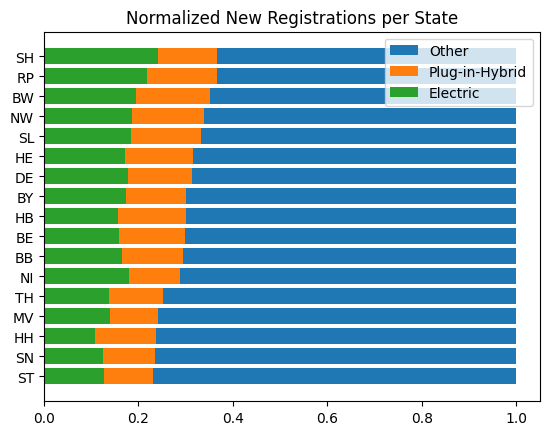

In [11]:
df2.sort_values('Percentage Electric', inplace=True)
plt.barh(df2['Abbreviation'], df2['NR Overall']/df2['NR Overall'])
plt.barh(df2['Abbreviation'], (df2['NR Plug-in-Hybrid']+df2['NR Electric'])/df2['NR Overall'])
plt.barh(df2['Abbreviation'], df2['NR Electric']/df2['NR Overall'])
plt.legend(['Other', 'Plug-in-Hybrid', 'Electric'])
plt.title('Normalized New Registrations per State')
plt.show()

To get another overview over the calculated values we display them on a map of Germany. <br>
For this we use GeoPandas and a shapes dataset with the german states from http://www.diva-gis.org/datadown. <br>
Download Link: https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip

In [12]:
# Download the needed file if not already existing
if not os.path.exists('./DEU_adm/'):
    import urllib.request
    import zipfile
    urllib.request.urlretrieve('https://biogeo.ucdavis.edu/data/diva/adm/DEU_adm.zip', 'DEU_adm.zip')
    with zipfile.ZipFile('DEU_adm.zip', 'r') as zip_ref:
        zip_ref.extractall('DEU_adm')
    os.remove('DEU_adm.zip')

In [13]:
# Create the dataframe and add the columns to investigate
df_ger = gpd.read_file('./DEU_adm/DEU_adm1.shp') 
df_ger = df_ger.set_index('NAME_1')
df_ger['Percentage Electric'] = df2['Percentage Electric']
df_ger['CP per km^2']  = df2['CP per km^2'] 

First we take a loot at the new registrations of electric powered cars (Full Electric + Plug-in-Hybrid).

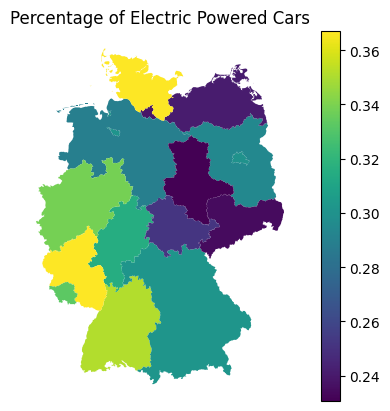

In [14]:
df_ger.plot(column='Percentage Electric', kind='geo', legend=True)
plt.axis('off')
plt.title('Percentage of Electric Powered Cars')
plt.show()

Then on the amount of charging points per square-kilometer.

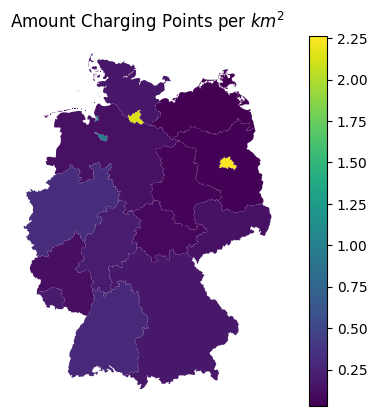

In [15]:
df_ger.plot(column='CP per km^2', kind='geo', legend=True)
plt.axis('off')
plt.title('Amount Charging Points per $km^2$')
plt.show()

As you notice, the states 'Bremen', 'Hamburg' and 'Berlin' stand out extremely from the other states. The reason for this that they are "Stadtstaaten", which means they are more like citys and have a much smaller area then the other "Bundesländer", what causes the much higher rate of CP per $km^2$. <br>
For this reason, we drop these states for the rest of the exploration.

In [16]:
# Drop out the "Stadtstaaten"
df2.drop(index=['Bremen', 'Berlin', 'Hamburg'], inplace=True)
df_ger.drop(index=['Bremen', 'Berlin', 'Hamburg'], inplace=True)

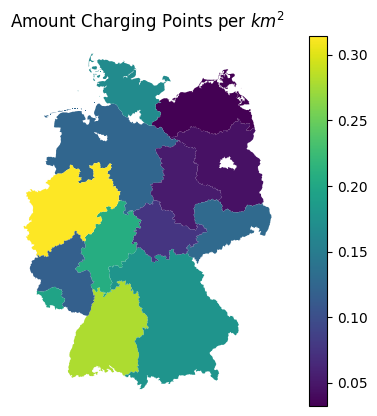

In [17]:
# Again plot the 'CP per km^2' value on the german map
df_ger.plot(column='CP per km^2', kind='geo', legend=True)
plt.axis('off')
plt.title('Amount Charging Points per $km^2$')
plt.show()

To look for a correlation between the percentage of electric powered cars and the amount of cp per $km^2$ we visualize the states in a scatter plot and try to fit a line.

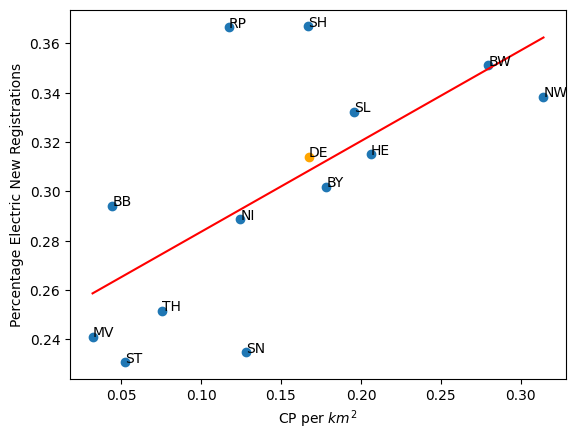

In [18]:
d = df2.drop(index=['Germany'])
x_col = 'CP per km^2'
y_col = 'Percentage Electric'
x = d[x_col]
y = d[y_col]
plt.scatter(x, y)
plt.xlabel('CP per $km^2$')
plt.ylabel('Percentage Electric New Registrations')

ger_x = df2.loc['Germany', x_col]
ger_y = df2.loc['Germany', y_col]
plt.scatter(ger_x, ger_y, c='orange')
plt.text(ger_x, ger_y, 'DE',)

# Fit a linear function
a, b = polyfit(x, y, 1)
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = b * x_fitted + a
plt.plot(x_fitted, y_fitted, 'r')

for state in d.index:
    ds = df2.loc[state]
    plt.text(ds[x_col], ds[y_col], ds['Abbreviation'])

plt.show()

For calculating different correlations, we first calculate new values similar to `CP per km^2` and `Percentage Electric`.

In [19]:
df2['SCP per km^2'] = df2['Amount SCP'] / df2['Area (km^2)']
df2['FCP per km^2'] = df2['Amount FCP'] / df2['Area (km^2)']

df2['Percentage Full-Electric'] = df2['NR Electric'] / df2['NR Overall']
df2['Percentage Plug-in-Hybrid'] = df2['NR Plug-in-Hybrid'] / df2['NR Overall']

For calculating the correlations we use the scipy function pearsonr, which calculates the pearons correlation coefficient and the associated p-value. <br>
Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [20]:
d = df2.drop(index='Germany')
cols1 = ['CP per km^2', 'SCP per km^2', 'FCP per km^2']
cols2 = ['Percentage Electric', 'Percentage Full-Electric', 'Percentage Plug-in-Hybrid']

correlations = []

for c1 in cols1:
    for c2 in cols2:
        corr, pvalue = pearsonr(d[c1], d[c2])
        correlations.append({
            'x':c1,
            'y':c2,
            'corr_coef':corr,
            'p_value':pvalue
        })

df_corr = pd.DataFrame(correlations, columns=['x','y','corr_coef', 'p_value'])
df_corr.sort_values('corr_coef', ascending=False)

,x,y,corr_coef,p_value
8,FCP per km^2,Percentage Plug-in-Hybrid,0.784702,0.001489
2,CP per km^2,Percentage Plug-in-Hybrid,0.779542,0.001678
5,SCP per km^2,Percentage Plug-in-Hybrid,0.771761,0.001998
6,FCP per km^2,Percentage Electric,0.689617,0.009106
0,CP per km^2,Percentage Electric,0.653076,0.015511
3,SCP per km^2,Percentage Electric,0.642030,0.017988
7,FCP per km^2,Percentage Full-Electric,0.535684,0.059188
1,CP per km^2,Percentage Full-Electric,0.487002,0.091441
4,SCP per km^2,Percentage Full-Electric,0.475752,0.100329


As we can see, the percentage of plug-in-hybrids has the highest correlations with the amounts of different charging points. <br>
For this reason, we have a look at the scatterplot from above again, but this time just with the percentage of plug-in-hybrids

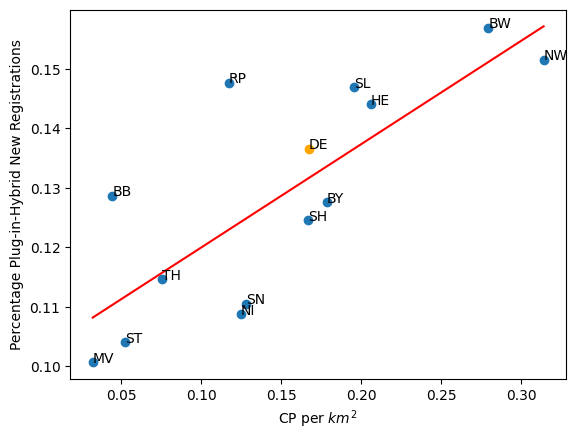

In [21]:
d = df2.drop(index=['Germany'])
x_col = 'CP per km^2'
y_col = 'Percentage Plug-in-Hybrid'
x = d[x_col]
y = d[y_col]
plt.scatter(x, y)
plt.xlabel('CP per $km^2$')
plt.ylabel('Percentage Plug-in-Hybrid New Registrations')

ger_x = df2.loc['Germany', x_col]
ger_y = df2.loc['Germany', y_col]
plt.scatter(ger_x, ger_y, c='orange')
plt.text(ger_x, ger_y, 'DE',)

# Fit a linear function
a, b = polyfit(x, y, 1)
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = b * x_fitted + a
plt.plot(x_fitted, y_fitted, 'r')

for state in d.index:
    ds = df2.loc[state]
    plt.text(ds[x_col], ds[y_col], ds['Abbreviation'])

plt.show()